In the attached spreadsheet, you are procider with c150,000 transactions from 6,000 users across multiple different retailers. There is a brief explanation in the sheet to clarify the data fields. Your challenge is to use the data to show off your data expertise. A predictive model, user segmentation, a beautiful visualization or a data pipeline. Anything! It is a blank canvas for you to show us what you can do...

### Mncedisi Mncwabe Reveal data Assessment

- To run and test that the code functions and produces results as expected, please update the location of the transactions excel file in the read_data function then run the code

In [3]:
# for analysis and data processing
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
# import libraries for predictive modelling
import lifetimes  # pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import BetaGeoBetaBinomFitter
from lifetimes.fitters.modified_beta_geo_fitter import ModifiedBetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_expected_repeat_purchases
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

In [12]:
def read_data(path_to_excel_file):
    '''
    Reads an excel file from a specified path

    Parameters:
            path to excel file location
    Returns:
            dataframe of imported excel file
    '''
    # Read excel file
    df = pd.read_excel(path_to_excel_file,sheet_name='Sheet1',index_col=0)
    
    return df

# call the function to import the excel file - update with your path where the file is located
transactions = read_data('/Path/To/Transactions/Excel/File/Transactions.xlsx')

## 1. Data Cleaning and Preparation
- This step is for understanding the data more, clean and process it for analysis and modelling

In [13]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'Transactions:')
df_snapshot(transactions)

Transactions:


,retailer,transaction_date,transaction_value,income_bracket,age,customer_id
56,Checkers,2024-01-30 09:00:00,331.04,"f:R20,000-30,000 pm",33.0,28905
153,Checkers,2024-01-30 09:00:00,121.35,"d:R10,000-15,000 pm",NaN,45092
167,Woolworths,2024-01-30 09:00:00,105.96,"d:R10,000-15,000 pm",NaN,45092
191,Checkers,2024-01-30 09:00:00,116.97,"f:R20,000-30,000 pm",29.0,81025
361,Woolworths,2024-01-30 09:00:00,698.46,"f:R20,000-30,000 pm",NaN,55841


In [14]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'transactions:')
data_types(transactions)

transactions:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 144690 entries, 56 to 144674
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   retailer           144690 non-null  object        
 1   transaction_date   144690 non-null  datetime64[ns]
 2   transaction_value  144690 non-null  float64       
 3   income_bracket     144690 non-null  object        
 4   age                87201 non-null   float64       
 5   customer_id        144690 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 7.7+ MB


- The transaction_date is in a datetime format, we will remove the timestamp component and work with the date component only

In [15]:
def null_checker(df):
    '''
    Returns the count of rows found in the dataframe where there is a null present.

    Parameters:
        df (Dataframe): Pandas dataframe

    Returns:
        Prints the null count, null percentage, and row count per column.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

# check nulls in train
print(f'transactions:')
null_checker(transactions)

transactions:
                   Null Count  Null Percentage  Row Count
age                     57489        39.732532     144690
retailer                    0         0.000000     144690
transaction_date            0         0.000000     144690
transaction_value           0         0.000000     144690
income_bracket              0         0.000000     144690
customer_id                 0         0.000000     144690


In [16]:
def count_customers_without_age(transactions_df):
    """
    Checks how many unique customers do not have an age recorded
    
    """
    # Filter the dataframe for rows where 'age' is NaN
    customers_no_age = transactions_df[transactions_df['age'].isna()]
    
    # Count unique customer IDs where 'age' is NaN
    unique_customers_no_age_count = customers_no_age['customer_id'].nunique()
    
    # Total number of unique customers in the entire dataset
    total_unique_customers = transactions_df['customer_id'].nunique()
    
    # Calculate the percentage of unique customers without an age record
    percentage_no_age = (unique_customers_no_age_count / total_unique_customers) * 100
    
    return unique_customers_no_age_count, percentage_no_age

# call the function
count_customers_without_age_result = count_customers_without_age(transactions)
count_customers_without_age_result

(2302, 42.25403817914831)

In [17]:
# check unique customers
transactions['customer_id'].nunique()

5448

In [18]:
# check min and max transaction date
transactions['transaction_date'].min(),transactions['transaction_date'].max()

(Timestamp('2023-11-01 09:00:00'), Timestamp('2024-01-30 09:00:00'))

- There's about 42% (2302 out of 5448) unique customers without an age record, we will use median imputation to account for customers without the age data recorded. This is imperative when we do machine learning modelling or segmentation since most ML or segmentation algorithms require handling of missing values before they are applied to the data.
- Another approach for this would be to better understand why these customers do not have age data recorded, then a more robust and better imputation strategy could be considered such as other means of getting these customers age data from other sources.
- For this exercise we will assume the missing age data was just due to data errors

In [19]:
def impute_missing_age_data(df,column):
    """
    Impute missing values for 'age' using median age
    
    """
    median_age = df[column].median()
    df[column] = df[column].fillna(median_age)
    
    return df

# call the function
impute_missing_age_data(transactions,'age')

,retailer,transaction_date,transaction_value,income_bracket,age,customer_id
56,Checkers,2024-01-30 09:00:00,331.04,"f:R20,000-30,000 pm",33.0,28905
153,Checkers,2024-01-30 09:00:00,121.35,"d:R10,000-15,000 pm",30.0,45092
167,Woolworths,2024-01-30 09:00:00,105.96,"d:R10,000-15,000 pm",30.0,45092
191,Checkers,2024-01-30 09:00:00,116.97,"f:R20,000-30,000 pm",29.0,81025
361,Woolworths,2024-01-30 09:00:00,698.46,"f:R20,000-30,000 pm",30.0,55841
...,...,...,...,...,...,...
144552,Shoprite,2023-11-01 09:00:00,2299.11,"c:R5,000-10,000 pm",26.0,33530
144621,Pick n Pay,2023-11-01 09:00:00,23.99,"c:R5,000-10,000 pm",24.0,51605
144631,PEP Home,2023-11-01 09:00:00,36.98,"c:R5,000-10,000 pm",33.0,61689
144663,Pick n Pay,2023-11-01 09:00:00,25.99,"c:R5,000-10,000 pm",33.0,37359


In [20]:
def convert_transaction_date_to_date(df,column):
    """
    Returns a dataframe with converted transaction_date from datetime to just date
    to disregard the timestamp component.
    
    """
    df[column] = pd.to_datetime(df[column]).dt.date
    
    return df

# call the function
convert_transaction_date_to_date(transactions,'transaction_date')

,retailer,transaction_date,transaction_value,income_bracket,age,customer_id
56,Checkers,2024-01-30,331.04,"f:R20,000-30,000 pm",33.0,28905
153,Checkers,2024-01-30,121.35,"d:R10,000-15,000 pm",30.0,45092
167,Woolworths,2024-01-30,105.96,"d:R10,000-15,000 pm",30.0,45092
191,Checkers,2024-01-30,116.97,"f:R20,000-30,000 pm",29.0,81025
361,Woolworths,2024-01-30,698.46,"f:R20,000-30,000 pm",30.0,55841
...,...,...,...,...,...,...
144552,Shoprite,2023-11-01,2299.11,"c:R5,000-10,000 pm",26.0,33530
144621,Pick n Pay,2023-11-01,23.99,"c:R5,000-10,000 pm",24.0,51605
144631,PEP Home,2023-11-01,36.98,"c:R5,000-10,000 pm",33.0,61689
144663,Pick n Pay,2023-11-01,25.99,"c:R5,000-10,000 pm",33.0,37359


In [21]:
def create_age_groups(df, age_column):
    """
   Creates age buckets for the age column

    """
    ages = df[age_column].values
    categories = []

    for age in ages:
        if 0 <= age <= 21:
            categories.append("0-21")
        elif 22 <= age <= 27:
            categories.append("22-27")
        elif 28 <= age <= 34:
            categories.append("28-34")
        elif 35 <= age <= 41:
            categories.append("35-41")
        elif 42 <= age <= 48:
            categories.append("42-48")
        elif 49 <= age <= 55:
            categories.append("49-55")
        else:
            categories.append("55+")

    df['age_group'] = categories

    return df

# call function
transactions = create_age_groups(transactions, 'age')
transactions.head()

,retailer,transaction_date,transaction_value,income_bracket,age,customer_id,age_group
56,Checkers,2024-01-30,331.04,"f:R20,000-30,000 pm",33.0,28905,28-34
153,Checkers,2024-01-30,121.35,"d:R10,000-15,000 pm",30.0,45092,28-34
167,Woolworths,2024-01-30,105.96,"d:R10,000-15,000 pm",30.0,45092,28-34
191,Checkers,2024-01-30,116.97,"f:R20,000-30,000 pm",29.0,81025,28-34
361,Woolworths,2024-01-30,698.46,"f:R20,000-30,000 pm",30.0,55841,28-34


## 2. Exploratory Data Analysis (EDA)
- This steps is for exploring the data, build some visualizations to extract insight from it

In [22]:
def descriptive_stats(df):
    '''
    Generates descriptive stats
    '''
    return df.describe()


descriptive_stats(transactions)

,transaction_value,age,customer_id
count,144690.000000,144690.000000,144690.000000
mean,224.978901,30.898569,49248.601444
std,359.706963,7.501791,28776.426215
min,0.010000,0.000000,1.000000
25%,43.102500,28.000000,24287.000000
50%,109.990000,30.000000,49222.000000
75%,258.000000,31.000000,73796.000000
max,15000.000000,100.000000,99979.000000


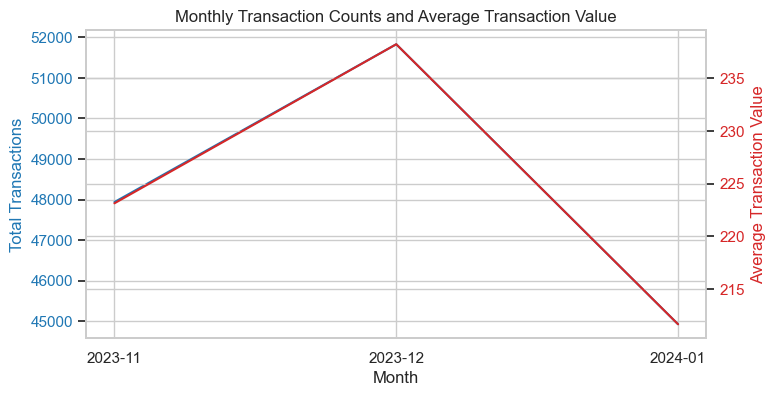

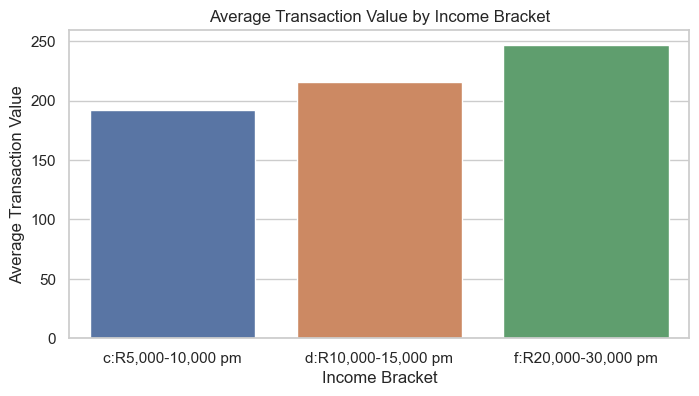

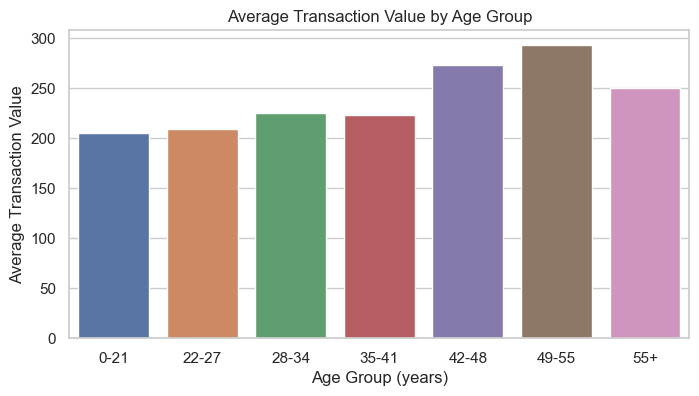

In [23]:
# Set up for visualizations
sns.set(style="whitegrid")

# Excract month
transactions['month'] = pd.to_datetime(transactions['transaction_date']).dt.to_period('M')

# 1. Transaction Trends Over Time
# Aggregate data by month
monthly_transactions = transactions.groupby('month').agg(total_transactions=('transaction_date', 'count'),
                                                             avg_transaction_value=('transaction_value', 'mean')).reset_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Transactions', color=color)
ax1.plot(monthly_transactions['month'].astype(str), monthly_transactions['total_transactions'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Average Transaction Value', color=color) 
ax2.plot(monthly_transactions['month'].astype(str), monthly_transactions['avg_transaction_value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Transaction Counts and Average Transaction Value')
plt.show()

# 2. Spending by Income Bracket
income_spending = transactions.groupby('income_bracket').agg(avg_transaction_value=('transaction_value', 'mean')).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='income_bracket', y='avg_transaction_value', data=income_spending)
plt.title('Average Transaction Value by Income Bracket')
plt.ylabel('Average Transaction Value')
plt.xlabel('Income Bracket')
plt.show()

# 3. Spending by Age Group
age_spending = transactions.groupby('age_group').agg(avg_transaction_value=('transaction_value', 'mean')).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='age_group', y='avg_transaction_value', data=age_spending)
plt.title('Average Transaction Value by Age Group')
plt.ylabel('Average Transaction Value')
plt.xlabel('Age Group (years)')
plt.show()

#### Monthly Transaction Trends:
- There's a notable variation in both the number of transactions and the average spending per month. This indicates potential seasonal trends or promotional effects that influence customer purchasing behavior over the different months, especially in December as it is higher compared to Nov and Jan.
#### Spending by Income Bracket:
- Higher income brackets correspond to higher average spending. Customers in the income bracket "R20,000-30,000 pm" have the highest average spending with an average of approximately R250, followed by those in the "R15,000-20,000 pm" and "d:R10,000-15,000 pm" brackets respectively. This suggests that income level is a significant predictor of spending capacity.
#### Spending by Age Group:
- The customers above the age of 40 years dominate in terms of average spending,averaging approximately R300 per transaction, indicating that these age ranges are likely more economically active or have higher disposable income than younger customers. 

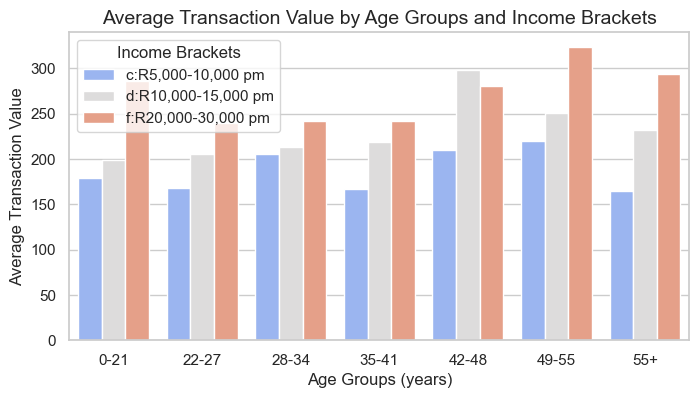

In [24]:
def plot_age_groups_vs_income(dataframe, age_group_col, income_bracket_col, transaction_value_col):
    """
   Plots the average transaction value by age groups and income brackets.

    """
    # Calculate the average transaction value per age group and income bracket
    avg_values = dataframe.groupby([age_group_col, income_bracket_col])[transaction_value_col].mean().reset_index()
    plt.figure(figsize=(8, 4))
    barplot = sns.barplot(
        x=age_group_col, 
        y=transaction_value_col, 
        hue=income_bracket_col, 
        data=avg_values, 
        palette='coolwarm',
        ci=None
    )

    plt.xlabel("Age Groups (years)", fontsize=12)
    plt.ylabel("Average Transaction Value", fontsize=12)
    plt.title("Average Transaction Value by Age Groups and Income Brackets", fontsize=14) 
    plt.legend(title="Income Brackets")
    plt.show()

# call function
plot_age_groups_vs_income(transactions, 'age_group', 'income_bracket', 'transaction_value')

#### Spendings by Age group vs Income group
- As noted, the older customer cohort (42+ years) tend to earn higher than younger customers (below 34 years) and their average spending is also high.
- From the "49-55" years age group there is a decrease in the average transaction value for the highest income bracket, this might suggest a change in spending habits or financial priorities as individuals approach retirement age.

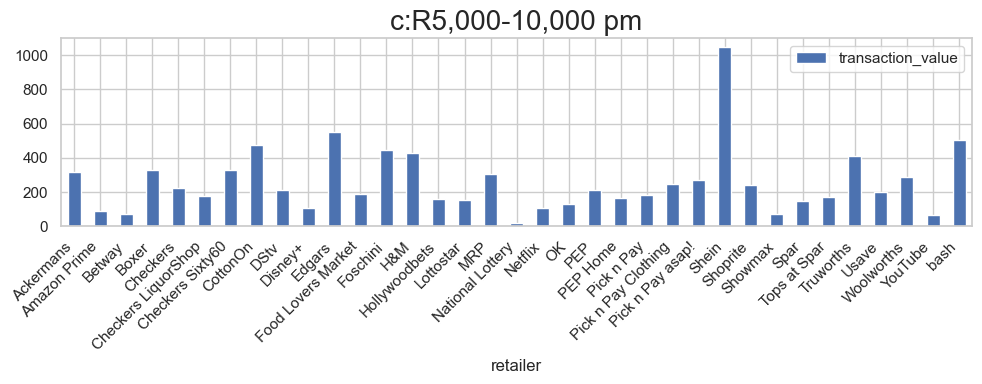

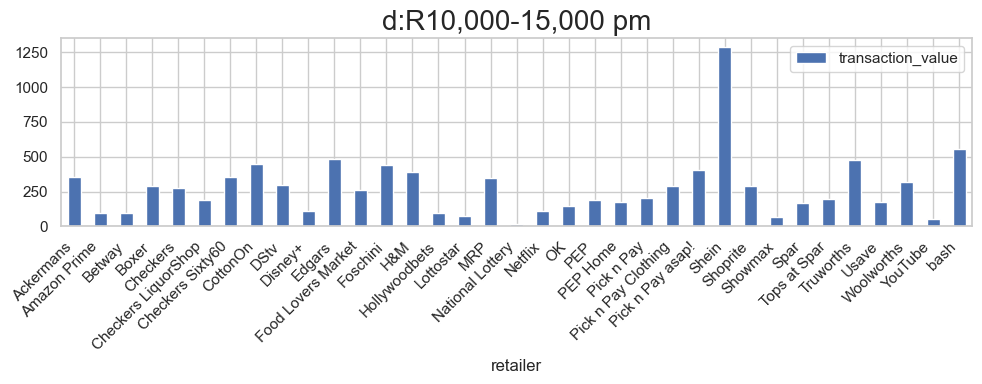

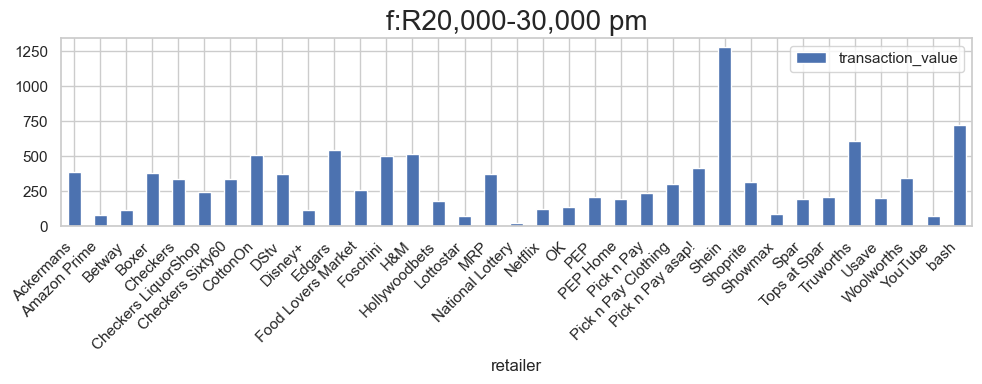

In [25]:
df_grouped = transactions.groupby(['retailer','income_bracket']).agg({
    'transaction_value': 'mean'
}).reset_index()

df_grouped.set_index(['retailer'], inplace=True)
for income_bracket in df_grouped.income_bracket.unique():
    ax = df_grouped[df_grouped.income_bracket==income_bracket].plot.bar(stacked=True,figsize=(10,4))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right",fontsize=11)
    ax.legend(loc='upper right')
    ax.set_title(income_bracket,fontsize=20)
    plt.tight_layout()

#### Insights from camparing average transaction value for each income brackers across different retailers

- Shein shows a notably high average transaction value compared to the rest of the retailers, with an average of R1000-R1300 per transaction across the 3 income brackets which is almost 2 times higher than the other retailers.
- The other clothing brands such as Bash, Edgars, Foschini, H&M, Truworths and CottonOn also seem to ve very appealing to customers across the 3 income brackers with average spendings rangine from R500-R700.
- Boxer seems to be a lot more appealing to customers in the lower-income brackets.

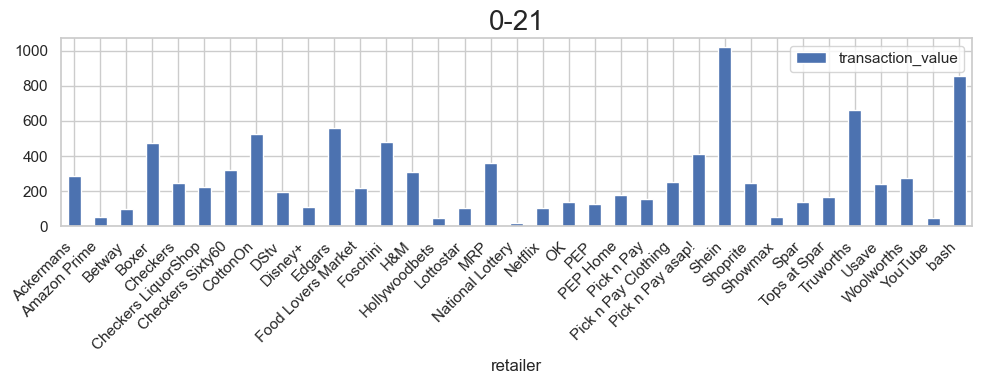

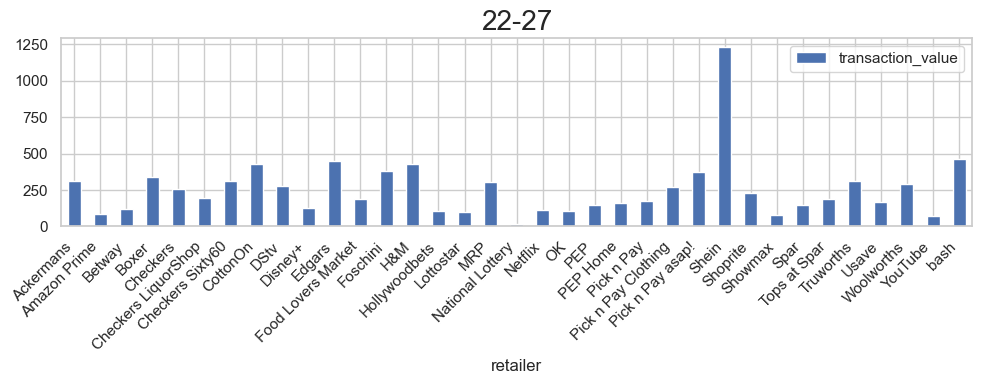

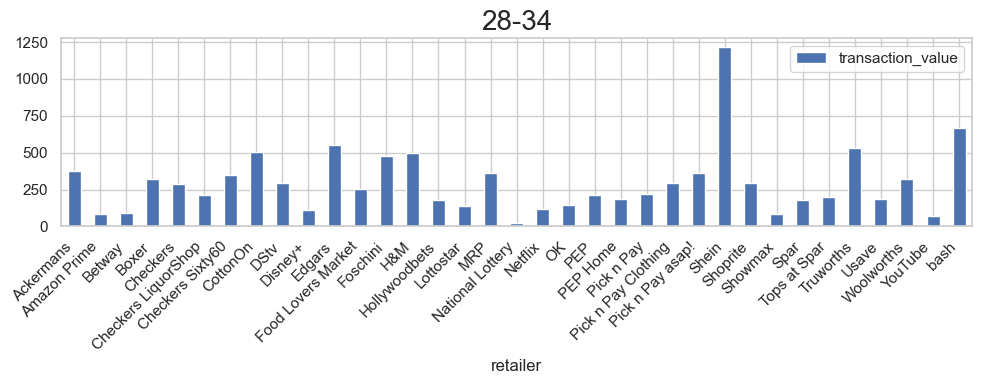

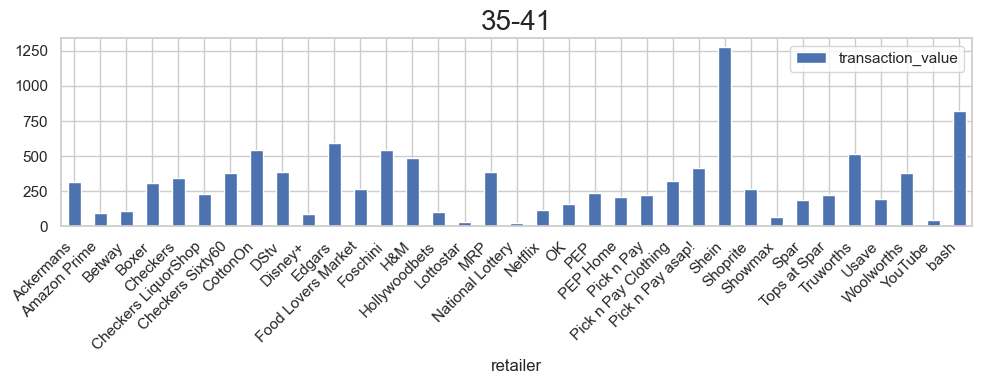

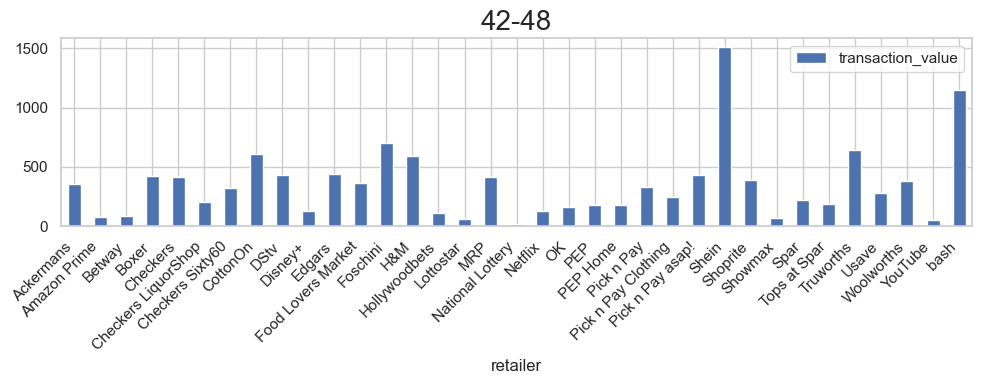

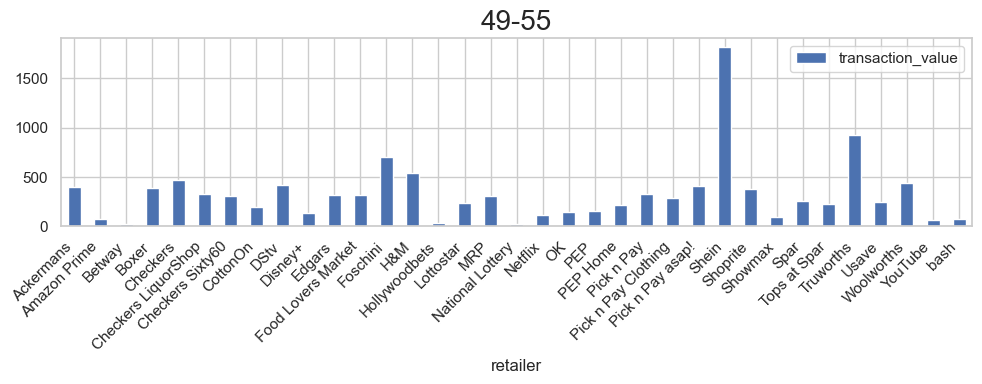

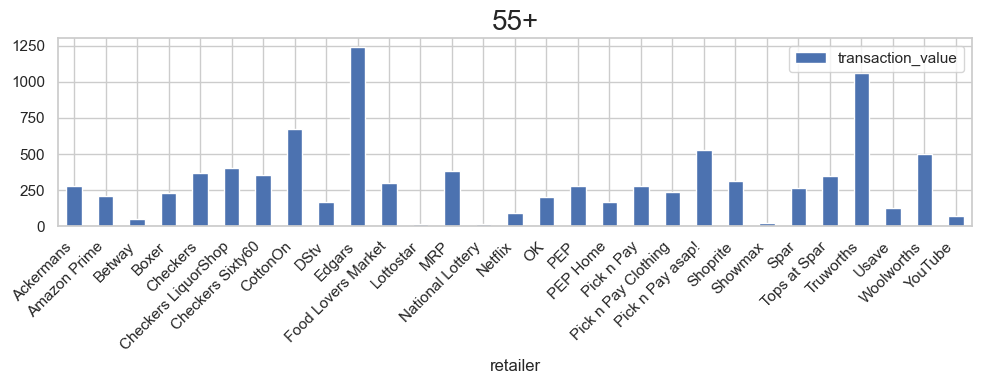

In [26]:
df_grouped2 = transactions.groupby(['retailer','age_group']).agg({
    'transaction_value': 'mean'
}).reset_index()

df_grouped2.set_index(['retailer'], inplace=True)
for age_group in df_grouped2.age_group.unique():
    ax = df_grouped2[df_grouped2.age_group==age_group].plot.bar(stacked=True,figsize=(10,4))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right",fontsize=11)
    ax.legend(loc='upper right')
    ax.set_title(age_group,fontsize=20)
    plt.tight_layout()

#### Insights from camparing average transaction value for each age group across different retailers
- Shein tends to have younger customers than the average customer (30 years), on the other hand Edgars seems to be more appealing to older customers with a spike in average transactions value for customers aged 55+ years.

In [27]:
def categorize_retailers(transactions, retailer_col):
    """
    Categorizes retailers into 'Food', 'Clothing', 'Liquor', 'Entertainment', 'Gambling', and 'Home'
    based on the retailer name and adds a new 'category' field to the transactions DataFrame.

    """
    
    # Define the categories based on retailer names
    food_retailers = ['Checkers', 'Woolworths', 'Spar', 'Checkers Sixty60', 'OK','Pick n Pay',
                      'Pick n Pay asap!', 'Food Lovers Market', 'Usave', 'Boxer', 'Shoprite']
    clothing_retailers = ['MRP', 'Pick n Pay Clothing', 'Ackermans', 'bash', 'H&M',
                          'Foschini', 'PEP', 'Shein', 'Truworths', 'Edgars', 'CottonOn']
    liquor_retailers = ['Tops at Spar', 'Checkers LiquorShop']
    entertainment_retailers = ['YouTube', 'DStv', 'Showmax', 'Disney+', 'Netflix', 'Amazon Prime']
    gambling_retailers = ['National Lottery', 'Betway', 'Hollywoodbets', 'Lottostar']
    home_retailers = ['PEP Home']
    
    # Function to determine category
    def get_category(retailer):
        if retailer in food_retailers:
            return 'Food'
        elif retailer in clothing_retailers:
            return 'Clothing'
        elif retailer in liquor_retailers:
            return 'Liquor'
        elif retailer in entertainment_retailers:
            return 'Entertainment'
        elif retailer in gambling_retailers:
            return 'Gambling'
        elif retailer in home_retailers:
            return 'Home'
        else:
            return 'Other' 
    
    # Apply the function to the retailer column to create a new category column
    transactions['category'] = transactions[retailer_col].apply(get_category)
    
    return transactions

# call function
transactions = categorize_retailers(transactions, 'retailer')
transactions

,retailer,transaction_date,transaction_value,income_bracket,age,customer_id,age_group,month,category
56,Checkers,2024-01-30,331.04,"f:R20,000-30,000 pm",33.0,28905,28-34,2024-01,Food
153,Checkers,2024-01-30,121.35,"d:R10,000-15,000 pm",30.0,45092,28-34,2024-01,Food
167,Woolworths,2024-01-30,105.96,"d:R10,000-15,000 pm",30.0,45092,28-34,2024-01,Food
191,Checkers,2024-01-30,116.97,"f:R20,000-30,000 pm",29.0,81025,28-34,2024-01,Food
361,Woolworths,2024-01-30,698.46,"f:R20,000-30,000 pm",30.0,55841,28-34,2024-01,Food
...,...,...,...,...,...,...,...,...,...
144552,Shoprite,2023-11-01,2299.11,"c:R5,000-10,000 pm",26.0,33530,22-27,2023-11,Food
144621,Pick n Pay,2023-11-01,23.99,"c:R5,000-10,000 pm",24.0,51605,22-27,2023-11,Food
144631,PEP Home,2023-11-01,36.98,"c:R5,000-10,000 pm",33.0,61689,28-34,2023-11,Home
144663,Pick n Pay,2023-11-01,25.99,"c:R5,000-10,000 pm",33.0,37359,28-34,2023-11,Food


FixedFormatter should only be used together with FixedLocator


<Figure size 1200x400 with 0 Axes>

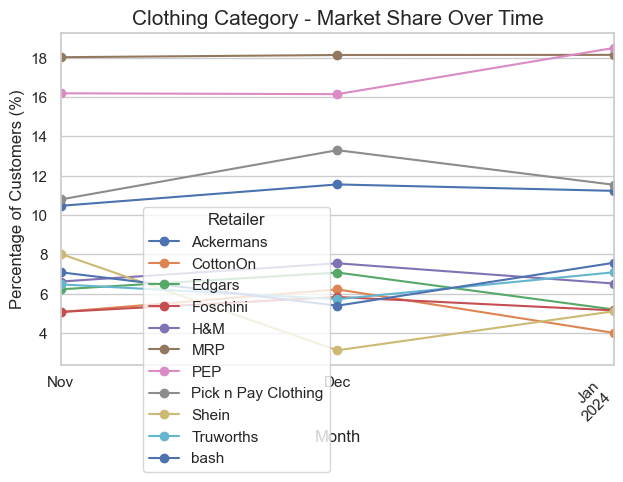

FixedFormatter should only be used together with FixedLocator


<Figure size 1200x400 with 0 Axes>

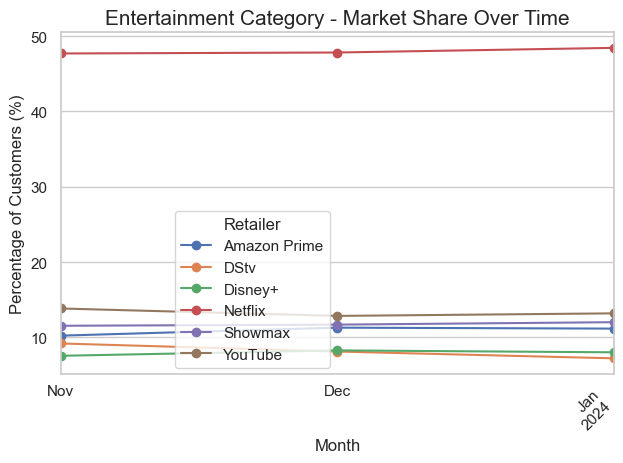

FixedFormatter should only be used together with FixedLocator


<Figure size 1200x400 with 0 Axes>

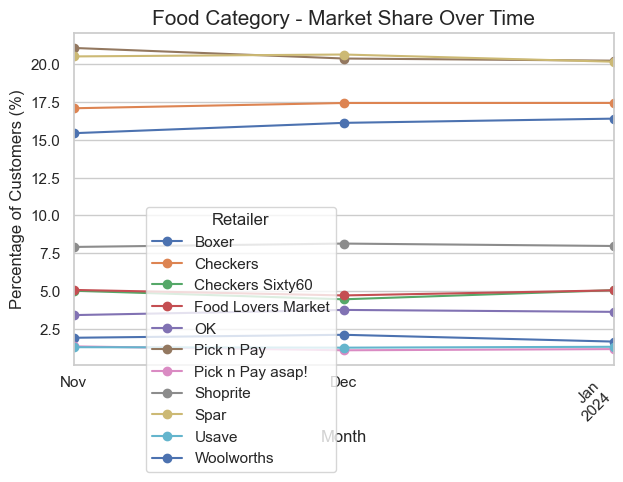

FixedFormatter should only be used together with FixedLocator


<Figure size 1200x400 with 0 Axes>

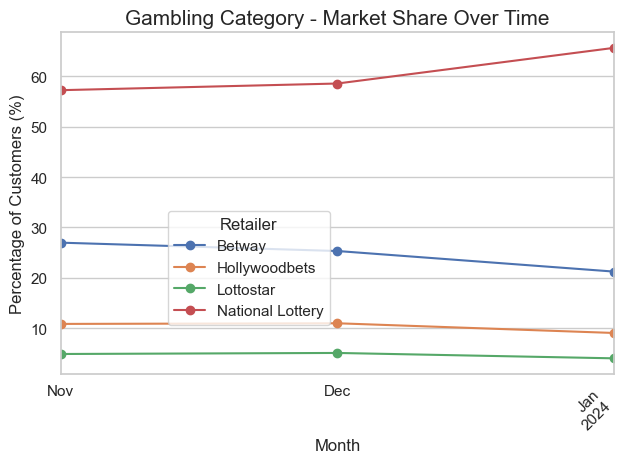

FixedFormatter should only be used together with FixedLocator


<Figure size 1200x400 with 0 Axes>

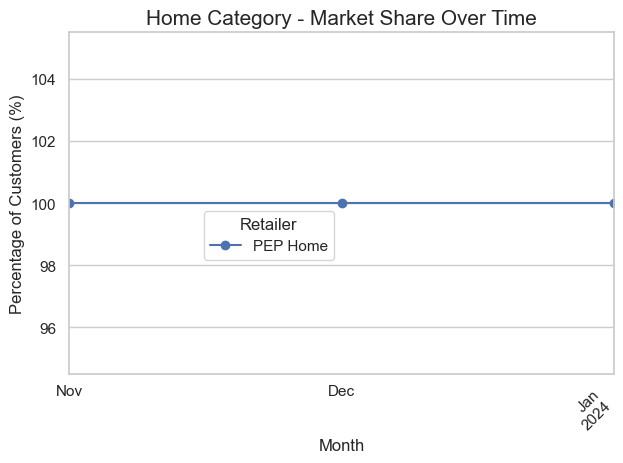

FixedFormatter should only be used together with FixedLocator


<Figure size 1200x400 with 0 Axes>

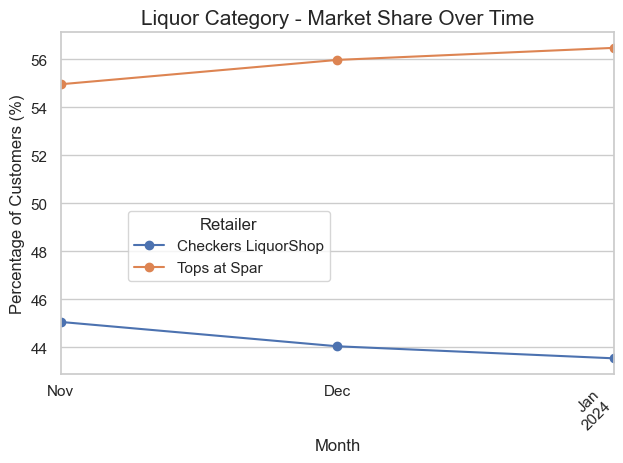

In [28]:
# Group by retailer, category, and month, then count unique customers
df_grouped = transactions.groupby(['month', 'category', 'retailer']).agg({
    'customer_id': 'nunique'
}).reset_index()

category_month_totals = df_grouped.groupby(['month', 'category'])['customer_id'].transform('sum')
df_grouped['customer_percentage'] = (df_grouped['customer_id'] / category_month_totals) * 100
for category in df_grouped['category'].unique():
    df_pivot = df_grouped[df_grouped['category'] == category].pivot(
        index='month', columns='retailer', values='customer_percentage'
    )
    
    df_pivot.sort_index(inplace=True)

    # Plotting
    plt.figure(figsize=(12, 4))
    ax = df_pivot.plot(kind='line', marker='o')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=11)
    ax.set_title(f'{category} Category - Market Share Over Time', fontsize=15)
    ax.set_ylabel('Percentage of Customers (%)', fontsize=12)
    ax.set_xlabel('Month', fontsize=12)
    ax.legend(title='Retailer', bbox_to_anchor=(0.5,0.5), loc="upper right")
    plt.tight_layout()
    plt.show()

### Market Share insights for each category
- MRP, PEP, bash and Pick n Pay Clothing have dominated the market share among the clothing retailers, with each having more than 10% per month. Intrestingly, Shein has a low market share of less than 8% per month compared to the other clothing retailers, even though we have seen a very high transaction value spending behaviour from Shein customers.
- Market Share Dominance: National Lottery dominates the market share among the presented gambling retailers, starting strong in November and continuing to grow through January.
- Pick n Pay, Spar and Checkers have dominated the market share among the food retailers, each having more than 20% per month.
- A notable decline in market share for CheckersLiquor, moving from 45% in Nov to approximately 42% in Jan 2024 while Spar Tops displayed a steady market share growth among the Liquor retailers.
- Netflix seems to have been a clear leader in market share among entertainment retailers, significantly outperforming others—remaining above 40% throughout the 3 month period. Other competitors like Amazon Prime, Disney+, Showmax, and YouTube have much lower and relatively stable market shares. They're clustered under the 20% line, indicating a significantly smaller portion of the market compared to the Netflix.

## 3. Customer Segmentation
- Here we create customer segments to group customers based on thier shopping behaviour using RFMD (Recency, Frequency, Monetary,Duration) segmentation modelling.
- Recency: How recently a customer has made a purchase. This will be the number of days since their last purchase as of the reference date. We will use reference date of 2024-02-01 to pretend as if it's the current date since the data ends on 2024-01-30.
- Frequency: How often a customer makes a purchase. This will be the count of unique transaction dates per customer.
- Monetary: How much money a customer has spent. This will be the sum of the transaction_value field for each customer.
- For Duration, this is thr numner of days between a customer's first transaction and their last transaction with the retailer.

This will be grouped by customer id, thier age group, income bracket and retailer. That is, a customer will show different RFMD values for each retailer/category, as their spending behaviour and association with the retailer might not be the same across all retailers/categories. Eg a customer might have just purchased food items more recent than they might have purchased a clothing item.

In [29]:
def create_RFM_segments(transactions_df, reference_date_str='2024-02-01'):
    """
    Creates RFMD (Recency, Frequency, Monetary, Duration) segmentation 

    """
    transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
    reference_date = pd.to_datetime(reference_date_str)
    
    # Calculate Recency, Frequency, Monetary and Duration for each customer per retailer
    recency = transactions_df.groupby(['customer_id', 'retailer'])['transaction_date'].max().apply(lambda date: (reference_date - date).days)
    frequency = transactions_df.groupby(['customer_id', 'retailer'])['transaction_date'].nunique()
    monetary = transactions_df.groupby(['customer_id', 'retailer'])['transaction_value'].sum()
    # Calculate the Duration for each customer per retailer
    first_transaction_date = transactions_df.groupby(['customer_id', 'retailer'])['transaction_date'].min()
    last_transaction_date = transactions_df.groupby(['customer_id', 'retailer'])['transaction_date'].max()
    duration = (last_transaction_date - first_transaction_date).dt.days
    
    rfm_df = pd.DataFrame({
        'Recency': recency,
        'Frequency': frequency,
        'Monetary': monetary,
        'Duration':duration
    }).reset_index()
    
    unique_customer_info = transactions_df[['customer_id', 'income_bracket', 'age_group','age']].drop_duplicates()
    rfm_grouped = pd.merge(
        rfm_df, 
        unique_customer_info, 
        on='customer_id'
    )
    
    return rfm_grouped

# call function
df_segmented = create_RFM_segments(transactions)

### RFMD Binning using quintiles approach

###### Below are functions that calculate RFMD score for each customer for each retailer:
- Each function first calculates the quintiles for its respective metric, dividing the dataset into four equal parts. 
- Then it assigns a score to each record based on these quintiles. 
- For Recency, a lower value is better (the more recent the customer's last purchase, the higher their Recency score).
- For Frequency, Monetary and Duration, higher values are better, so the scores are assigned in direct relation to the quintile thresholds (the more frequent a customer's purchases, or the greater the monetary value of their transactions and the higher thier duration means longer term assocation with the retailer, the higher their respective score).


Subsequently,  we will have one combined variable called RFMD which combines these 4 different variables to give us an indication of different customer groups. E.g a customer RFMD of 4444 (or a sum of 4+4+4+4=16) means they have more recently purhcased in that retailer, has a high frequency and transaction value and long term association, and those could be high valuable customers for that retailer. On the other hand, the same customer could have an RFMD score of 1111 (or sum of 1+1+1+1=4) at another retailer which means they don't buy often, don't spend a lot on thier trasactions and have also not purchased in a while from that retailer.
So the most valuable customer will be the one with RFMD score of 4444 or 16, while the least valuable will have RFM score of 1111 or 4.

In [30]:
tqdm.pandas()

def r_score(data):
    '''
    Assigns a Recency score to each customer based on the quintiles of recency distribution.
    The score is inversely related to the recency of their last purchase, 
    the more recent the purchase, the higher the score.
    
    '''
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['R'] = [4 if x <= quintiles['Recency'][.25] else 3 if x <= quintiles['Recency'][.50] else 2 if x <= quintiles['Recency'][.75] else 1 for x in data.Recency]
    return data


def f_score(data):
    '''
    Assigns a Frequency score to each customer based on the quintiles of frequency distribution.
    The score is directly related to the transaction frequency,
    the more frequent the transactions, the higher the score.
    '''
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['F'] = [1 if x <= quintiles['Frequency'][.25] else 2 if x <= quintiles['Frequency'][.50] else 3 if x <= quintiles['Frequency'][.75] else 4 for x in data.Frequency]
    return data


def m_score(data):
    '''
    Assigns a Monetary score to each customer based on the quintiles of monetary distribution.
    The score is directly related to the monetary value of the transactions, 
    the higher the monetary value, the higher the score.
    '''
    
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['M'] = [1 if x <= quintiles['Monetary'][.25] else 2 if x <= quintiles['Monetary'][.50] else 3 if x <= quintiles['Monetary'][.75] else 4 for x in data.Monetary]
    return data

def d_score(data):
    '''
    Assigns a Duration score to each customer based on the quintiles of Duration distribution.
    The score is directly related to the duration value, 
    the higher the duration value, the higher the score.
    '''
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['D'] = [1 if x <= quintiles['Duration'][.25] else 2 if x <= quintiles['Duration'][.50] else 3 if x <= quintiles['Duration'][.75] else 4 for x in data.Duration]
    return data

# apply functions
df_segmented = df_segmented.groupby(['retailer']).progress_apply(lambda df: r_score(df))
df_segmented = df_segmented.groupby(['retailer']).progress_apply(lambda df: f_score(df))
df_segmented = df_segmented.groupby(['retailer']).progress_apply(lambda df: m_score(df))
df_segmented = df_segmented.groupby(['retailer']).progress_apply(lambda df: d_score(df))
# RFMD scores
df_segmented['RFMD_Score'] = df_segmented['R'].map(str) + df_segmented['F'].map(str) + df_segmented['M'].map(str) + df_segmented['D'].map(str)
df_segmented['RFMD_Score'] = df_segmented['RFMD_Score'].astype(int)
df_segmented['RFMD'] = df_segmented[['R','F','M','D']].sum(axis=1)

df_segmented.head()

100%|██████████| 35/35 [00:00<00:00, 397.12it/s]


,customer_id,retailer,Recency,Frequency,Monetary,Duration,income_bracket,age_group,age,R,F,M,D,RFMD_Score,RFMD
0,1,Ackermans,65,1,832.85,0,"c:R5,000-10,000 pm",28-34,34.0,1,1,4,1,1141,7
1,1,Checkers,2,17,4450.85,90,"c:R5,000-10,000 pm",28-34,34.0,4,4,4,4,4444,16
2,1,Checkers LiquorShop,2,14,4726.91,90,"c:R5,000-10,000 pm",28-34,34.0,4,4,4,4,4444,16
3,1,MRP,39,1,399.97,0,"c:R5,000-10,000 pm",28-34,34.0,3,1,3,1,3131,8
4,1,PEP,55,4,404.44,8,"c:R5,000-10,000 pm",28-34,34.0,2,4,3,3,2433,12


In [31]:
def rfmd_segment(df):
    if ((df['R'] >= 3) and (df['F'] >= 3) and (df['M'] < 3)):
        return 'Deal Hunters'
    elif ((df['R'] < 3) and (df['F'] >= 3) and (df['M'] >= 3)):
        return 'Rising Stars'
    elif ((df['R'] >= 4) and (df['F'] >= 4) and (df['M'] >= 4) and (df['D'] >= 3)):
        return 'Best Customers'
    elif ((df['F'] < 2) and (df['M'] >= 4)):
        return 'High-spender Once-Off Customers'
    elif  ((df['R'] <= 1) and (df['F'] <= 1) and (df['M'] <= 2)):
        return 'Lost New Buyers'
    else:
        return 'Promising'
    
# Create RFM_segment field
df_segmented['RFMD_Segment'] = df_segmented.apply(rfmd_segment, axis=1)
df_segmented['RFMD_Segment'] = df_segmented.apply(rfmd_segment, axis=1)
df_segmented.head()

,customer_id,retailer,Recency,Frequency,Monetary,Duration,income_bracket,age_group,age,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment
0,1,Ackermans,65,1,832.85,0,"c:R5,000-10,000 pm",28-34,34.0,1,1,4,1,1141,7,High-spender Once-Off Customers
1,1,Checkers,2,17,4450.85,90,"c:R5,000-10,000 pm",28-34,34.0,4,4,4,4,4444,16,Best Customers
2,1,Checkers LiquorShop,2,14,4726.91,90,"c:R5,000-10,000 pm",28-34,34.0,4,4,4,4,4444,16,Best Customers
3,1,MRP,39,1,399.97,0,"c:R5,000-10,000 pm",28-34,34.0,3,1,3,1,3131,8,Promising
4,1,PEP,55,4,404.44,8,"c:R5,000-10,000 pm",28-34,34.0,2,4,3,3,2433,12,Rising Stars


#### Descriptions of the RFMD Customer Segments

- Best Customers – This group consists of customers who transacted more recently, do so more frequently, spend more than other customers, showing a long term engagement and spending behaviour with the correponding retailer. These are the loyal and most valuable customers (bring more revenue than other customers).
- High-spender Once-Off Customers – This group consists of customers who transacted only once with a certail retailer, haven't purchased in a while but spent a huge amount of money. 
- Deal Hunters – This group consists of those customers who transacted more recently and do so often, but are low-spenders.They are very engaged with the retailer, they just do not spend much on their purchases.
- Rising Stars – This is a segment of customers who transacted more often and spent a lot on their purchases, but it’s been while since they’ve transacted with that particular retailer. Chances are they are dormant. These customers could be turned to Best customers group.
- Lost New Buyers - They only transacted once, long time ago and spent a little.
- Promising — customers showing promising signs of becoming engaged customers.


In [32]:
rfm_segment_agg = df_segmented.groupby('RFMD_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'age': 'mean',
    'customer_id': 'nunique'
})
rfm_segment_agg

,Recency,Frequency,Monetary,Duration,age,customer_id
RFMD_Segment,,,,,,
Best Customers,5.172426,12.900691,3813.590091,75.873045,31.442706,1812
Deal Hunters,13.645244,3.874679,332.176382,49.496144,29.314267,1202
High-spender Once-Off Customers,46.550699,1.014860,1382.863435,0.518357,30.680070,961
Lost New Buyers,69.565145,1.038174,177.090824,1.074481,29.999170,2964
Promising,27.601085,2.893212,770.314947,26.663999,30.270879,5189
Rising Stars,43.283723,4.844386,1518.484902,34.925772,30.582140,1862


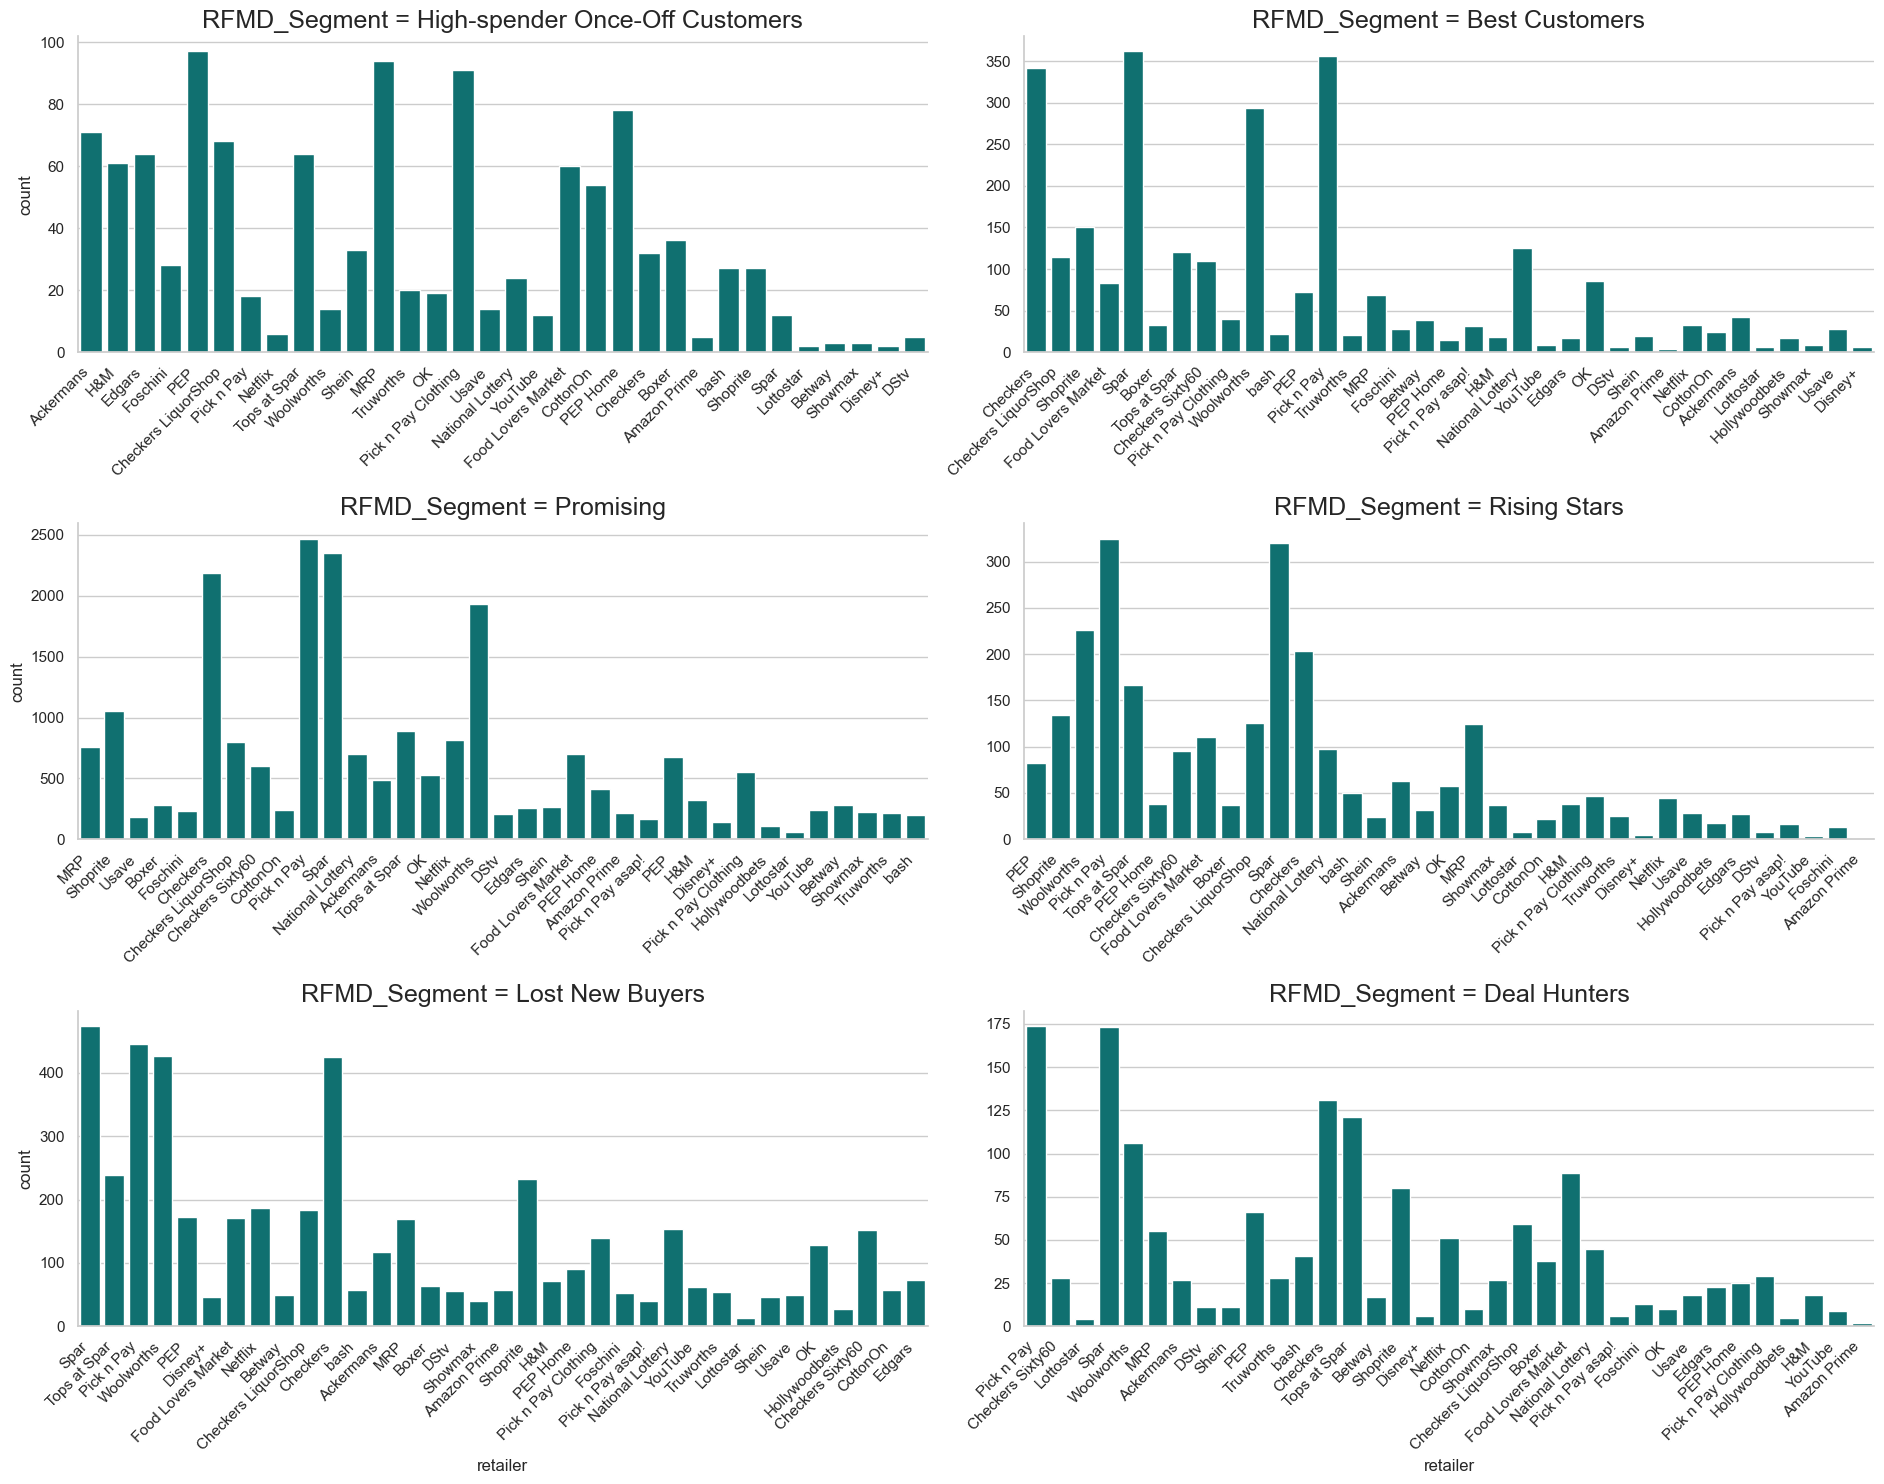

In [33]:
g = sns.catplot(x="retailer", col="RFMD_Segment",data=df_segmented, kind="count",height=5,color='teal',
                aspect=1.9,sharex=False,sharey=False,col_wrap=2)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
g.set_titles(size=18)
g.tight_layout()

 #### Insights from Customer Segmentation
 - The Best customers (33%) average have the lowest recency of less than a week (5 days), which indicates most recent purchases, they also have the highest frequency, and highest average transaction value. They also have the highest Duration showing their long term association with the retailers they purchase from.
- Deal Hunters - These customers show relatively low recency of less than 2 weeks, they shop relatively more often but are low spenders. These customers show engagement so they could be targeted with promotional products by retailers.
- High-spender Once-Off Customers have transacted in more than 45 days once but have spent notably high amount of money, these are customers who can be turned to Best customers when there are strategies to keep them more engaged and purchasing more frequently.

#### Segments by retailer
- Pick n Pay, Checkers, Spar and Woolworths share majority of the The Best customer segments, this is not suripsing that this is from Food retailers as customers more often purchase food items.
- On the other hand PEP, PEP Home, MRP and Pick n Pay Clothing have a high number of one-time high-spending customers. As these are more associated with clothing and home appliances it's not surpising that this customer segment only come to buy such items.
- The Deal Hunters segment seem to be enticed by Spar, Spar Tops and PnP. This could indicate that these Retailers with a larger share of deal hunters could run frequent promotions or have a wide range of lower price point products, attracting cost-sensitive customers.

#### How can these segments be valueable for investors

- Investors can gauge market position by looking at retailers like Pick n Pay, Checkers, Spar, and Woolworths, which share the majority of the Best customer segments. A large proportion of loyal customers indicates a strong market position and provides a predictable revenue stream
- The insights on PEP, PEP Home, MRP, and Pick n Pay Clothing, which have a high number of one-time high-spending customers, can inform investors about the potential for revenue spikes, which may be less predictable but significant. These retailers may be attractive for their ability to draw in customers for occasional large purchases.

## 4. Predictive Modelling using BetaGeoFitter and ParetoNBDFitter 
- BG/NBD - Beta Geometric/Negative Binomial Distribution - This is the probabilistic model for predicting a customer's lifetime value and future transactions.
- This model allows us to predict a customer's number of purchases in the next t days given thier historical Recency, Frequency and Duration at a retailer.
- We can also predict the probabity of a customer to make a purchase in the next t days using the ParetoNBDFitter

In [35]:
### Fit the model
df_segmented['Recency'] = np.where((df_segmented['Recency']>df_segmented['Duration']),df_segmented['Duration'],df_segmented['Recency'])
df_pred = df_segmented.groupby(["Frequency", "Recency", "Duration"]).size().reset_index()
bgf = BetaGeoFitter(penalizer_coef = 0.9999)
bgf.fit(df_pred['Frequency'],df_pred['Recency'],df_pred['Duration'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 7592 subjects, a: 0.21, alpha: 0.30, b: 0.40, r: 0.38>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.375030,0.004279,0.366644,0.383416
alpha,0.303502,0.006965,0.289851,0.317152
a,0.214909,0.003249,0.208542,0.221276
b,0.404459,0.005188,0.394290,0.414627


In [36]:
# Predict a customer's number of orders/purchases in the next 60 days at each retailer
t = 60
df_segmented['predicted_orders'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_segmented['Frequency'], df_segmented['Recency'], df_segmented['Duration'])
df_segmented.head()

,customer_id,retailer,Recency,Frequency,Monetary,Duration,income_bracket,age_group,age,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders
0,1,Ackermans,0,1,832.85,0,"c:R5,000-10,000 pm",28-34,34.0,1,1,4,1,1141,7,High-spender Once-Off Customers,6.427074e+01
1,1,Checkers,2,17,4450.85,90,"c:R5,000-10,000 pm",28-34,34.0,4,4,4,4,4444,16,Best Customers,1.716610e-25
2,1,Checkers LiquorShop,2,14,4726.91,90,"c:R5,000-10,000 pm",28-34,34.0,4,4,4,4,4444,16,Best Customers,6.988762e-21
3,1,MRP,0,1,399.97,0,"c:R5,000-10,000 pm",28-34,34.0,3,1,3,1,3131,8,Promising,6.427074e+01
4,1,PEP,8,4,404.44,8,"c:R5,000-10,000 pm",28-34,34.0,2,4,3,3,2433,12,Rising Stars,2.162628e+01


In [37]:
# Customer example - predicted number of purchases
pd.set_option('display.float_format', lambda s: '%.4f' % s)
df_segmented[df_segmented['customer_id']==47714][['customer_id','retailer','Recency','Frequency','Duration','predicted_orders']].sort_values(by='predicted_orders', ascending=False).head()

,customer_id,retailer,Recency,Frequency,Duration,predicted_orders
16992,47714,MRP,0,1,0,64.2707
16994,47714,Pick n Pay,0,1,0,64.2707
16993,47714,PEP,27,4,27,7.6861
16991,47714,Checkers,20,2,20,4.9298
16996,47714,Woolworths,2,2,64,0.0048


#### Random Customer = 47714 example to explain model predictions
For customer_id = 47714, the model predicts that this customer will make 7 orders from PEP in the next 60 days. To calculate this, the model takes the customer's Duration with PEP (27 days) and Frequency (4 times), meaning at this retailer this customer made 4 purchases in 27 days (from their first to last transaction at PEP), which means the customer was making 4/27=0.14 orders a day. Therefore, at this rate, in the next 60 days they're predicted to make 0.14*60 = 8.4 orders (close to the predicted value of 7.6 orders).

For Checkers the model predicts that this customer will make approximately 5 (4.9) purchases in the next 60 days. Thier frequency is 2 and a Duration of 20, which means in 20 days they made 2/20=0.1 purchases. At this rate they are predicted to make 0.1*60 = 6 purchases in the next 60 days.

#### Predict Customer's probability to make a purchase in the next t days

In [38]:
par = ParetoNBDFitter(penalizer_coef=0.01) 
par.fit(df_pred['Frequency'],df_pred['Recency'],df_pred['Duration'])
print(par) 

<lifetimes.ParetoNBDFitter: fitted with 7592 subjects, alpha: 0.57, beta: 20.47, r: 0.62, s: 1.29>


In [39]:
# Probability to make a purchase in the next 60 days
t = 60
n = 1
df_segmented['prob_to_buy'] = par.conditional_probability_of_n_purchases_up_to_time(n,t, df_segmented['Frequency'], df_segmented['Recency'], df_segmented['Duration'])
df_segmented.head()

,customer_id,retailer,Recency,Frequency,Monetary,Duration,income_bracket,age_group,age,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_to_buy
0,1,Ackermans,0,1,832.8500,0,"c:R5,000-10,000 pm",28-34,34.0000,1,1,4,1,1141,7,High-spender Once-Off Customers,64.2707,0.0365
1,1,Checkers,2,17,4450.8500,90,"c:R5,000-10,000 pm",28-34,34.0000,4,4,4,4,4444,16,Best Customers,0.0000,0.0000
2,1,Checkers LiquorShop,2,14,4726.9100,90,"c:R5,000-10,000 pm",28-34,34.0000,4,4,4,4,4444,16,Best Customers,0.0000,0.0000
3,1,MRP,0,1,399.9700,0,"c:R5,000-10,000 pm",28-34,34.0000,3,1,3,1,3131,8,Promising,64.2707,0.0365
4,1,PEP,8,4,404.4400,8,"c:R5,000-10,000 pm",28-34,34.0000,2,4,3,3,2433,12,Rising Stars,21.6263,0.0737


In [40]:
# Customer example 47714 - probability to make 1 purchase in the next 60 days.
pd.set_option('display.float_format', lambda s: '%.4f' % s)
df_segmented[df_segmented['customer_id']==47714][['customer_id','retailer','Recency','Frequency','Duration','predicted_orders','prob_to_buy']].sort_values(by='predicted_orders', ascending=False).head()

,customer_id,retailer,Recency,Frequency,Duration,predicted_orders,prob_to_buy
16992,47714,MRP,0,1,0,64.2707,0.0365
16994,47714,Pick n Pay,0,1,0,64.2707,0.0365
16993,47714,PEP,27,4,27,7.6861,0.1160
16991,47714,Checkers,20,2,20,4.9298,0.1540
16996,47714,Woolworths,2,2,64,0.0048,0.0001


### Other considerations
These are just some of the things that can be considered for the future analysis to understand the customer's spending decisions even more, but we can keep it at this for the scope of this assessment and the data at hand.
- The models fitted on this data are baseline models, i.e no parameter tuning implemented,
- Compare current models performances with other models such as Regression models for predictiong a customer's Monetaty value or future transactions.
- Enrich the data and customer segments with more features such as types of products that customers purchase and drill further into their behaviour

### ----------------------------------------------------------------------END----------------------------------------------------------------------------------